<a href="https://colab.research.google.com/github/Darkcoder1995/Graph-Neural-Network/blob/main/Graph_Transformer_ETA_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00


In [ ]:
!pip install torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 62.5 MB/s eta 0:00:00


In [ ]:
!pip install sodapy

In [ ]:
!pip install openrouteservice

In [ ]:
import os
import requests
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv
from torch_geometric.loader import NeighborLoader
from sodapy import Socrata
from geopy.distance import geodesic

from sklearn.neighbors import BallTree
import numpy as np
import requests
import time

import openrouteservice
from tqdm import tqdm
from openrouteservice import Client
from openrouteservice.exceptions import ApiError
import time
from sklearn.preprocessing import StandardScaler
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
import torch.optim as optim
from torch_scatter import scatter
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

In [ ]:
# Step 1: Download Green Taxi Trip Data (Sept 2015)
client = Socrata("data.cityofnewyork.us", None)
results = client.get("gi8d-wdg5", limit=10000)
results_df = pd.DataFrame.from_records(results)

In [ ]:
min_pickup_datetime = results_df['lpep_pickup_datetime'].min()
max_dropoff_datetime = results_df['lpep_dropoff_datetime'].max()

In [ ]:
# URL of the station file
url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"

# Define fixed-width column specs (0-based indexing, end is exclusive)
colspecs = [
    (0, 11),   # ID
    (12, 20),  # LATITUDE
    (21, 30),  # LONGITUDE
    (31, 37),  # ELEVATION
    (38, 40),  # STATE
    (41, 71),  # NAME
    (72, 75),  # GSN FLAG
    (76, 79),  # HCN/CRN FLAG
    (80, 85),  # WMO ID
]

# Define column names
column_names = [
    "station_id", "latitude", "longitude", "elevation", "state",
    "name", "gsn_flag", "hcn_crn_flag", "wmo_id"
]

# Read the file using read_fwf (fixed-width format)
stations_df = pd.read_fwf(url, colspecs=colspecs, names=column_names)

# Display a few rows
print(stations_df.head())

    station_id  latitude  longitude  elevation state                   name  \
0  ACW00011604   17.1167   -61.7833       10.1   NaN  ST JOHNS COOLIDGE FLD   
1  ACW00011647   17.1333   -61.7833       19.2   NaN               ST JOHNS   
2  AE000041196   25.3330    55.5170       34.0   NaN    SHARJAH INTER. AIRP   
3  AEM00041194   25.2550    55.3640       10.4   NaN             DUBAI INTL   
4  AEM00041217   24.4330    54.6510       26.8   NaN         ABU DHABI INTL   

  gsn_flag hcn_crn_flag   wmo_id  
0      NaN          NaN      NaN  
1      NaN          NaN      NaN  
2      GSN          NaN  41196.0  
3      NaN          NaN  41194.0  
4      NaN          NaN  41217.0  


In [ ]:
# Ensure all coordinate columns are numeric
stations_df['latitude'] = pd.to_numeric(stations_df['latitude'], errors='coerce')
stations_df['longitude'] = pd.to_numeric(stations_df['longitude'], errors='coerce')

results_df['pickup_latitude'] = pd.to_numeric(results_df['pickup_latitude'], errors='coerce')
results_df['pickup_longitude'] = pd.to_numeric(results_df['pickup_longitude'], errors='coerce')
results_df['dropoff_latitude'] = pd.to_numeric(results_df['dropoff_latitude'], errors='coerce')
results_df['dropoff_longitude'] = pd.to_numeric(results_df['dropoff_longitude'], errors='coerce')

In [ ]:
# Convert to radians for Haversine distance
weather_coords = np.radians(stations_df[['latitude', 'longitude']].values)
pickup_coords = np.radians(results_df[['pickup_latitude', 'pickup_longitude']].values)
dropoff_coords = np.radians(results_df[['dropoff_latitude', 'dropoff_longitude']].values)

# Build BallTree using weather station coordinates
tree = BallTree(weather_coords, metric='haversine')

# Find nearest station index for each pickup and dropoff
pickup_dist, pickup_idx = tree.query(pickup_coords, k=1)
dropoff_dist, dropoff_idx = tree.query(dropoff_coords, k=1)

# Map nearest station details back to results_df
results_df['pickup_station_id'] = stations_df.iloc[pickup_idx.flatten()]['station_id'].values
results_df['pickup_station_lat'] = stations_df.iloc[pickup_idx.flatten()]['latitude'].values
results_df['pickup_station_lon'] = stations_df.iloc[pickup_idx.flatten()]['longitude'].values

results_df['dropoff_station_id'] = stations_df.iloc[dropoff_idx.flatten()]['station_id'].values
results_df['dropoff_station_lat'] = stations_df.iloc[dropoff_idx.flatten()]['latitude'].values
results_df['dropoff_station_lon'] = stations_df.iloc[dropoff_idx.flatten()]['longitude'].values

KeyboardInterrupt: 

In [ ]:
# NOAA API setup
TOKEN = "MFymOYvQmUjLkLmwBZxzzzRxrcWnGVqj"
headers = {'token': TOKEN}
base_url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"

# Prepare unique station IDs from both pickup and dropoff
unique_stations = pd.unique(
    pd.concat([
        results_df['pickup_station_id'],
        results_df['dropoff_station_id']
    ])
)

# Ensure dates are in YYYY-MM-DD format strings
start_date = pd.to_datetime(results_df['lpep_pickup_datetime'].min()).strftime("%Y-%m-%d")
end_date = pd.to_datetime(results_df['lpep_dropoff_datetime'].max()).strftime("%Y-%m-%d")

# Dictionary to hold weather data for each station-date
weather_dict = {}

for station_id in unique_stations:
    full_station_id = f"GHCND:{station_id}"

    # Set API parameters
    params = {
        'datasetid': 'GHCND',
        'stationid': full_station_id,
        'startdate': start_date,
        'enddate': end_date,
        'limit': 1000,       # NOAA limits responses; consider pagination
        'units': 'metric'
    }

    try:
        response = requests.get(base_url, headers=headers, params=params)
        response.raise_for_status()  # Raise error for bad responses
        data = response.json()

        # Parse response data
        for item in data.get('results', []):
            date = item['date'][:10]
            key = (station_id, date)  # Tuple key: (station_id, date)
            if key not in weather_dict:
                weather_dict[key] = {}
            weather_dict[key][item['datatype']] = item['value']

        time.sleep(1)  # Be polite to NOAA API (1-second delay)

    except Exception as e:
        print(f"Error fetching data for station {station_id}: {e}")

In [ ]:
weather_df = pd.DataFrame([
    {'station_id': sid, 'date': date, **metrics}
    for (sid, date), metrics in weather_dict.items()
])

In [ ]:
for column in weather_df.columns:
    if weather_df[column].isnull().any():
        median_value = weather_df[column].median()
        weather_df[column] = weather_df[column].fillna(median_value)

In [ ]:
# 1. Ensure date format
results_df['pickup_date'] = pd.to_datetime(results_df['lpep_pickup_datetime']).dt.date
results_df['dropoff_date'] = pd.to_datetime(results_df['lpep_dropoff_datetime']).dt.date
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.date

# 2. Rename weather columns BEFORE merging (avoid suffix conflicts)
pickup_weather_df = weather_df.rename(columns=lambda col: f"pickup_{col}" if col not in ['station_id', 'date'] else col)
dropoff_weather_df = weather_df.rename(columns=lambda col: f"dropoff_{col}" if col not in ['station_id', 'date'] else col)

# 3. Merge pickup weather (INNER)
pickup_matched = results_df.merge(
    pickup_weather_df,
    left_on=['pickup_station_id', 'pickup_date'],
    right_on=['station_id', 'date'],
    how='inner'
).drop(columns=['station_id', 'date'])

# 4. Pickup unmatched
pickup_unmatched = results_df.merge(
    pickup_weather_df[['station_id', 'date']],
    left_on=['pickup_station_id', 'pickup_date'],
    right_on=['station_id', 'date'],
    how='left',
    indicator=True
).query("_merge == 'left_only'").drop(columns=['station_id', 'date', '_merge'])

# Add missing pickup weather as 0
for col in pickup_weather_df.columns:
    if col not in ['station_id', 'date']:
        pickup_unmatched[col] = 0

# 5. Combine both pickup matched and unmatched
results_df_pickup = pd.concat([pickup_matched, pickup_unmatched], ignore_index=True)

# 6. Merge dropoff weather (INNER)
dropoff_matched = results_df_pickup.merge(
    dropoff_weather_df,
    left_on=['dropoff_station_id', 'dropoff_date'],
    right_on=['station_id', 'date'],
    how='inner'
).drop(columns=['station_id', 'date'])

# 7. Dropoff unmatched
dropoff_unmatched = results_df_pickup.merge(
    dropoff_weather_df[['station_id', 'date']],
    left_on=['dropoff_station_id', 'dropoff_date'],
    right_on=['station_id', 'date'],
    how='left',
    indicator=True
).query("_merge == 'left_only'").drop(columns=['station_id', 'date', '_merge'])

# Add missing dropoff weather as 0
for col in dropoff_weather_df.columns:
    if col not in ['station_id', 'date']:
        dropoff_unmatched[col] = 0

# 8. Combine matched + unmatched to form final dataset
results_df_final = pd.concat([dropoff_matched, dropoff_unmatched], ignore_index=True)

# 9. Final cleanup (in case 'station_id' and 'date' columns are present)
results_df_final.drop(columns=['station_id', 'date'], inplace=True, errors='ignore')

In [ ]:
# Check for NaN values in each column of results_df
nan_counts = results_df_final.isnull().sum()

# Print the count of NaN values for each column
if nan_counts.any():
    print("Columns with NaN values:")
    print(nan_counts)
else:
    print("No columns with NaN values.")

No columns with NaN values.


In [ ]:
api_key = '5b3ce3597851110001cf6248e5517d57f84a48f79ade0b581ebe78cf'

In [ ]:
# USE THIS-----
# ORS client already initialized
client = openrouteservice.Client(key=api_key)

# Create list of coordinate pairs
coordinates = list(zip(
    results_df_final['pickup_longitude'],
    results_df_final['pickup_latitude'],
    results_df_final['dropoff_longitude'],
    results_df_final['dropoff_latitude']
))

# ORS supports up to 50 locations in matrix request; do batches
batch_size = 50
durations = []
distances = []

for i in tqdm(range(0, len(coordinates), batch_size)):
    batch = coordinates[i:i+batch_size]

    # Prepare source and destination coordinates
    locations = [[lon1, lat1] for lon1, lat1, lon2, lat2 in batch]
    destinations = [[lon2, lat2] for lon1, lat1, lon2, lat2 in batch]

    try:
        matrix = client.distance_matrix(
            locations=locations + destinations,
            sources=list(range(len(locations))),
            destinations=list(range(len(locations), len(locations) + len(destinations))),
            metrics=["distance", "duration"],
            resolve_locations=True,
            units='m'
        )

        # Each result is row i's pickup to row i's dropoff
        durations.extend([row[i] for i, row in enumerate(matrix['durations'])])
        distances.extend([row[i] for i, row in enumerate(matrix['distances'])])

    except ApiError as e:
        print(f"API Error on batch {i}: {e}")
        durations.extend([None]*len(batch))
        distances.extend([None]*len(batch))
        time.sleep(5)
        continue
    except Exception as e:
        print(f"General error on batch {i}: {e}")
        durations.extend([None]*len(batch))
        distances.extend([None]*len(batch))
        time.sleep(5)
        continue

    # Be polite to the API
    time.sleep(1)

# Add back to DataFrame
results_df_final['ors_distance_m'] = distances
results_df_final['ors_duration_s'] = durations

100%|██████████| 200/200 [06:28<00:00,  1.94s/it]


In [ ]:
# # # prompt: where will it be saved

# results_df_final.to_csv('processed_taxi_data.csv', index=False)

In [ ]:
# # # # prompt: read results_df_final csv file
# #
results_df_final = pd.read_csv('processed_taxi_data (1).csv')

In [ ]:
pd.set_option('display.max_columns', None)

display(results_df_final)

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,pickup_station_id,pickup_station_lat,pickup_station_lon,dropoff_station_id,dropoff_station_lat,dropoff_station_lon,pickup_date,dropoff_date,pickup_PRCP,pickup_SNOW,pickup_SNWD,pickup_WESF,pickup_WESD,pickup_DAPR,pickup_MDPR,pickup_ADPT,pickup_ASLP,pickup_ASTP,pickup_AWBT,pickup_AWND,pickup_RHAV,pickup_RHMN,pickup_RHMX,pickup_TMAX,pickup_TMIN,pickup_WDF2,pickup_WDF5,pickup_WSF2,pickup_WSF5,pickup_WT01,pickup_WT08,pickup_WT04,pickup_WT02,pickup_WT06,pickup_TAVG,pickup_WT09,pickup_WT03,dropoff_PRCP,dropoff_SNOW,dropoff_SNWD,dropoff_WESF,dropoff_WESD,dropoff_DAPR,dropoff_MDPR,dropoff_ADPT,dropoff_ASLP,dropoff_ASTP,dropoff_AWBT,dropoff_AWND,dropoff_RHAV,dropoff_RHMN,dropoff_RHMX,dropoff_TMAX,dropoff_TMIN,dropoff_WDF2,dropoff_WDF5,dropoff_WSF2,dropoff_WSF5,dropoff_WT01,dropoff_WT08,dropoff_WT04,dropoff_WT02,dropoff_WT06,dropoff_TAVG,dropoff_WT09,dropoff_WT03,ors_distance_m,ors_duration_s
0,1,2015-02-13T19:49:20.000,2015-02-13T19:53:49.000,N,1,-73.994896,40.684578,-74.003479,40.680717,2,0.70,5.0,1.0,0.5,0.00,0.0,0.3,6.80,2,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-13,2015-02-13,0.3,0.0,80.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,0.3,0.0,80.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,1189.78,190.70
1,2,2015-02-26T19:17:29.000,2015-02-26T19:22:41.000,N,1,-73.993149,40.692768,-74.002129,40.684917,1,0.93,5.0,1.0,0.5,1.36,0.0,0.3,8.16,1,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-26,2015-02-26,0.0,0.0,127.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,0.0,0.0,127.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,1729.93,298.64
2,2,2015-02-17T14:10:19.000,2015-02-17T14:20:44.000,N,1,-73.991631,40.685059,-73.996834,40.680424,1,0.98,8.0,0.0,0.5,0.00,0.0,0.3,8.80,2,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-17,2015-02-17,3.0,76.0,229.0,3.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,3.0,76.0,229.0,3.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,1009.86,104.94
3,2,2015-02-06T21:07:34.000,2015-02-06T21:13:26.000,N,1,-73.910004,40.775623,-73.890762,40.768871,1,1.32,6.5,0.5,0.5,0.00,0.0,0.3,7.80,2,1,USW00014732,40.7794,-73.8803,USW00014732,40.7794,-73.8803,2015-02-06,2015-02-06,0.0,0.0,150.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,5.5,55.5,38.0,76.0,-2.7,-11.0,260.0,260.0,10.3,13.9,1.0,1.0,1.0,1.0,1.0,-7.7,1.0,1.0,0.0,0.0,150.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,5.5,55.5,38.0,76.0,-2.7,-11.0,260.0,260.0,10.3,13.9,1.0,1.0,1.0,1.0,1.0,-7.7,1.0,1.0,2146.68,211.62
4,1,2015-02-19T08:41:04.000,2015-02-19T08:49:17.000,N,1,-74.000633,40.682995,-73.989708,40.702469,1,1.90,8.5,0.0,0.5,1.85,0.0,0.3,11.15,1,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-19,2015-02-19,0.0,0.0,203.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,0.0,0.0,203.0,0.0,0.0,5.0,17.65,-89.0,10207.0,10179.0,-39.0,4.4,55.5,38.0,76.0,2.8,-6.0,280.0,290.0,9.4,12.5,1.0,1.0,1.0,1.0,1.0,0.4,1.0,1.0,3206.94,401.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
# prompt: drop ors_duration_s from result_df

results_df_final = results_df_final.drop(columns=['ors_duration_s'], errors='ignore')

In [ ]:
# Define weather columns (pickup + dropoff)
weather_columns = [
    'pickup_PRCP', 'pickup_SNOW', 'pickup_SNWD', 'pickup_WESF', 'pickup_WESD', 'pickup_DAPR',
    'pickup_MDPR', 'pickup_ADPT', 'pickup_ASLP', 'pickup_ASTP', 'pickup_AWBT', 'pickup_AWND',
    'pickup_RHAV', 'pickup_RHMN', 'pickup_RHMX', 'pickup_TMAX', 'pickup_TMIN', 'pickup_WDF2',
    'pickup_WDF5', 'pickup_WSF2', 'pickup_WSF5', 'pickup_WT01', 'pickup_WT08', 'pickup_WT04',
    'pickup_WT02', 'pickup_WT06', 'pickup_TAVG', 'pickup_WT09', 'pickup_WT03',
    'dropoff_PRCP', 'dropoff_SNOW', 'dropoff_SNWD', 'dropoff_WESF', 'dropoff_WESD', 'dropoff_DAPR',
    'dropoff_MDPR', 'dropoff_ADPT', 'dropoff_ASLP', 'dropoff_ASTP', 'dropoff_AWBT', 'dropoff_AWND',
    'dropoff_RHAV', 'dropoff_RHMN', 'dropoff_RHMX', 'dropoff_TMAX', 'dropoff_TMIN', 'dropoff_WDF2',
    'dropoff_WDF5', 'dropoff_WSF2', 'dropoff_WSF5', 'dropoff_WT01', 'dropoff_WT08', 'dropoff_WT04',
    'dropoff_WT02', 'dropoff_WT06', 'dropoff_TAVG', 'dropoff_WT09', 'dropoff_WT03'
]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler



# Combine trip-related and weather columns
scale_columns = [
    'trip_distance', 'passenger_count', 'fare_amount', 'tip_amount',
    'total_amount', 'ors_distance_m'
] + weather_columns  # Include weather data

# Ensure numeric types (coerce non-numeric to NaN)
results_df_final[scale_columns] = results_df_final[scale_columns].apply(pd.to_numeric, errors='coerce')

# Remove or replace invalid (negative or NaN) values
# Option 1: Fill NaNs with small value before log (safer for log1p)
results_df_final[scale_columns] = results_df_final[scale_columns].fillna(0)

# Optionally clip negatives if log1p is not safe for < -1
results_df_final[scale_columns] = results_df_final[scale_columns].clip(lower=0)

# Step 1: Apply log1p
results_df_final_log = results_df_final.copy()
results_df_final_log[scale_columns] = np.log1p(results_df_final_log[scale_columns])

# Step 2: Scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(results_df_final_log[scale_columns])

# Step 3: Replace the original values with the scaled ones
results_df_final[scale_columns] = scaled_features

In [ ]:
pd.set_option('display.max_columns', None)

results_df_final

,vendorid,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,pickup_station_id,pickup_station_lat,pickup_station_lon,dropoff_station_id,dropoff_station_lat,dropoff_station_lon,pickup_date,dropoff_date,pickup_PRCP,pickup_SNOW,pickup_SNWD,pickup_WESF,pickup_WESD,pickup_DAPR,pickup_MDPR,pickup_ADPT,pickup_ASLP,pickup_ASTP,pickup_AWBT,pickup_AWND,pickup_RHAV,pickup_RHMN,pickup_RHMX,pickup_TMAX,pickup_TMIN,pickup_WDF2,pickup_WDF5,pickup_WSF2,pickup_WSF5,pickup_WT01,pickup_WT08,pickup_WT04,pickup_WT02,pickup_WT06,pickup_TAVG,pickup_WT09,pickup_WT03,dropoff_PRCP,dropoff_SNOW,dropoff_SNWD,dropoff_WESF,dropoff_WESD,dropoff_DAPR,dropoff_MDPR,dropoff_ADPT,dropoff_ASLP,dropoff_ASTP,dropoff_AWBT,dropoff_AWND,dropoff_RHAV,dropoff_RHMN,dropoff_RHMX,dropoff_TMAX,dropoff_TMIN,dropoff_WDF2,dropoff_WDF5,dropoff_WSF2,dropoff_WSF5,dropoff_WT01,dropoff_WT08,dropoff_WT04,dropoff_WT02,dropoff_WT06,dropoff_TAVG,dropoff_WT09,dropoff_WT03,ors_distance_m
0,1,2015-02-13T19:49:20.000,2015-02-13T19:53:49.000,N,1,-73.994896,40.684578,-74.003479,40.680717,0.965753,-1.060010,-1.027300,1.0,0.5,-0.701732,0.0,0.3,-0.908004,2,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-13,2015-02-13,0.709677,-0.134989,2.173632,-0.057541,0.0,2.397423,2.397423,-0.010001,2.397441,2.397456,-0.029056,2.438829,2.399235,2.397858,2.401102,2.569046,-0.027917,2.434504,2.435545,2.431984,2.403901,2.397423,2.397423,2.397423,2.397423,2.397423,2.128072,2.397423,2.397423,0.567285,-0.170781,1.947323,-0.044969,-0.010001,2.177748,2.176942,-0.017323,2.17730,2.177342,-0.05087,2.311575,2.180210,2.179062,2.183394,2.479477,-0.047916,2.275094,2.265444,2.266365,2.201435,2.177275,2.177275,2.177275,2.177275,2.177275,1.627991,2.177275,2.177275,-0.732381
1,2,2015-02-26T19:17:29.000,2015-02-26T19:22:41.000,N,1,-73.993149,40.692768,-74.002129,40.684917,-0.389058,-0.841263,-1.027300,1.0,0.5,0.571171,0.0,0.3,-0.624486,1,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-26,2015-02-26,-0.150230,-0.134989,2.442349,-0.057541,0.0,2.397423,2.397423,-0.010001,2.397441,2.397456,-0.029056,2.438829,2.399235,2.397858,2.401102,2.569046,-0.027917,2.434504,2.435545,2.431984,2.403901,2.397423,2.397423,2.397423,2.397423,2.397423,2.128072,2.397423,2.397423,-0.176234,-0.170781,2.195816,-0.044969,-0.010001,2.177748,2.176942,-0.017323,2.17730,2.177342,-0.05087,2.311575,2.180210,2.179062,2.183394,2.479477,-0.047916,2.275094,2.265444,2.266365,2.201435,2.177275,2.177275,2.177275,2.177275,2.177275,1.627991,2.177275,2.177275,-0.410823
2,2,2015-02-17T14:10:19.000,2015-02-17T14:20:44.000,N,1,-73.991631,40.685059,-73.996834,40.680424,-0.389058,-0.797171,-0.333401,0.0,0.5,-0.701732,0.0,0.3,-0.505350,2,1,US1NYKN0025,40.6846,-73.9867,US1NYKN0025,40.6846,-73.9867,2015-02-17,2015-02-17,4.393393,8.218358,2.786509,17.379019,0.0,2.397423,2.397423,-0.010001,2.397441,2.397456,-0.029056,2.438829,2.399235,2.397858,2.401102,2.569046,-0.027917,2.434504,2.435545,2.431984,2.403901,2.397423,2.397423,2.397423,2.397423,2.397423,2.128072,2.397423,2.397423,3.752409,6.755797,2.514075,18.733551,-0.010001,2.177748,2.176942,-0.017323,2.17730,2.177342,-0.05087,2.311575,2.180210,2.179062,2.183394,2.479477,-0.047916,2.275094,2.265444,2.266365,2.201435,2.177275,2.177275,2.177275,2.177275,2.177275,1.627991,2.177275,2.177275,-0.873201
3,2,2015-02-06T21:07:34.000,2015-02-06T21:13:26.000,N,1,-73.910004,40.775623,-73.890762,40.768871,-0.389058,-0.523985,-0.645420,0.5,0.5,-0.701732,0.0,0.3,-0.695213,2,1,USW00014732,40.7794,-73.8803,USW00014732,40.7794,-73.8803,2015-02-06,2015-02-06,-0.150230,-0.134989,2.539392,-0.057541,0.0,2.397423,2.397423,-0.010001,2.397441,2.397456,-0.029056,2.752429,2.399235,2.397858,2.401102,-0.375731,-0.027917,2.397182,2.380860,2.532928,2.510825,2.397423,2.397423,2.397423,2.397423,2.3974

In [ ]:
# # Calculate the difference
# results_df_final['duration_difference'] = results_df_final['trip_duration'] - results_df_final['ors_duration_s']

# # Calculate Q1 and Q3 for the difference
# Q1 = results_df_final['duration_difference'].quantile(0.25)
# Q3 = results_df_final['duration_difference'].quantile(0.75)

# # Calculate IQR
# IQR = Q3 - Q1

# # Define outlier bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identify outliers
# outliers = results_df_final[
#     (results_df_final['duration_difference'] < lower_bound) |
#     (results_df_final['duration_difference'] > upper_bound)
# ]

# # Display the outliers
# print("Outliers in duration difference:")
# print(outliers[['trip_duration', 'ors_duration_s', 'duration_difference']])

In [ ]:
# # Make sure datetime columns are parsed correctly
# results_df_final['lpep_pickup_datetime'] = pd.to_datetime(results_df_final['lpep_pickup_datetime'])
# results_df_final['lpep_dropoff_datetime'] = pd.to_datetime(results_df_final['lpep_dropoff_datetime'])

# # Calculate trip duration
# results_df_final['trip_duration'] = (
#     results_df_final['lpep_dropoff_datetime'] - results_df_final['lpep_pickup_datetime']
# ).dt.total_seconds() / 60

# # Define weather columns
# weather_columns = [col for col in results_df_final.columns if col.startswith('pickup_') or col.startswith('dropoff_')]

# features = []
# targets = []

# for i, row in results_df_final.iterrows():
#     try:
#         trip_distance = pd.to_numeric(row['trip_distance'], errors='coerce')
#         passenger_count = pd.to_numeric(row['passenger_count'], errors='coerce')
#         fare_amount = pd.to_numeric(row['fare_amount'], errors='coerce')
#         tip_amount = pd.to_numeric(row['tip_amount'], errors='coerce')
#         total_amount = pd.to_numeric(row['total_amount'], errors='coerce')
#         ors_distance_m = pd.to_numeric(row['ors_distance_m'], errors='coerce')
#         ors_duration_s = pd.to_numeric(row['ors_duration_s'], errors='coerce')

#         base_features = [
#             trip_distance,
#             passenger_count,
#             fare_amount,
#             tip_amount,
#             total_amount,
#             ors_distance_m,
#             ors_duration_s
#         ]

#         weather_features = [
#             pd.to_numeric(row[col], errors='coerce') for col in weather_columns
#         ]

#         feature_vector = [0 if pd.isna(f) else f for f in base_features + weather_features]

#         features.append(feature_vector)
#         targets.append(row['trip_duration'])

#     except Exception as e:
#         print(f"❌ Skipping row {i} due to error: {e}")
#         # Optionally print the row causing the error for debugging
#         # print(row)

# # try:
# #     # Convert to NumPy array
# #     features_np = np.array(features, dtype=np.float32)

# #     # ✅ Apply XGBoost for feature importance
# #     from xgboost import XGBRegressor
# #     xgb_model = XGBRegressor()
# #     xgb_model.fit(features_np, results_df_final['trip_duration'])

# #     importances = xgb_model.feature_importances_
# #     top_n_idx = np.argsort(importances)[::-1][:15]  # Top 15 features

# #     selected_features = features_np[:, top_n_idx]

# #     # ✅ Apply PCA
# #     from sklearn.decomposition import PCA
# #     pca = PCA(n_components=0.95)  # Or fixed: n_components=32
# #     features_pca = pca.fit_transform(selected_features)

# #     # ✅ Convert to torch tensors
# #     X = torch.tensor(features_pca, dtype=torch.float)
# #     y = torch.tensor(targets, dtype=torch.float)

# #     print("✅ Feature tensor shape:", X.shape)
# #     print("✅ Target tensor shape:", y.shape)

# # except ValueError as e:
# #     print(f"❌ Error converting features to numpy array: {e}")
# #     print("Please check the 'features' list for non-numeric values.")

In [ ]:
# # Ensure datetime columns are parsed correctly
# results_df_final['lpep_pickup_datetime'] = pd.to_datetime(results_df_final['lpep_pickup_datetime'])
# results_df_final['lpep_dropoff_datetime'] = pd.to_datetime(results_df_final['lpep_dropoff_datetime'])

# # Calculate trip duration in minutes
# results_df_final['trip_duration'] = (
#     results_df_final['lpep_dropoff_datetime'] - results_df_final['lpep_pickup_datetime']
# ).dt.total_seconds() / 60

# # Extract weather-related columns
# weather_columns = [col for col in results_df_final.columns if col.startswith('pickup_') or col.startswith('dropoff_')]

# features = []
# targets = []

# # Feature construction
# for i, row in results_df_final.iterrows():
#     try:
#         base_features = [
#             pd.to_numeric(row['trip_distance'], errors='coerce'),
#             pd.to_numeric(row['passenger_count'], errors='coerce'),
#             pd.to_numeric(row['fare_amount'], errors='coerce'),
#             pd.to_numeric(row['tip_amount'], errors='coerce'),
#             pd.to_numeric(row['total_amount'], errors='coerce'),
#             pd.to_numeric(row['ors_distance_m'], errors='coerce'),
#             pd.to_numeric(row['ors_duration_s'], errors='coerce')
#         ]

#         weather_features = [pd.to_numeric(row[col], errors='coerce') for col in weather_columns]
#         feature_vector = [0 if pd.isna(f) else f for f in base_features + weather_features]

#         features.append(feature_vector)
#         targets.append(row['trip_duration'])

#     except Exception as e:
#         print(f"❌ Skipping row {i} due to error: {e}")

In [ ]:
# # Ensure datetime columns are parsed correctly
# results_df_final['lpep_pickup_datetime'] = pd.to_datetime(results_df_final['lpep_pickup_datetime'])
# results_df_final['lpep_dropoff_datetime'] = pd.to_datetime(results_df_final['lpep_dropoff_datetime'])

# # Calculate trip duration in minutes
# results_df_final['trip_duration'] = (
#     results_df_final['lpep_dropoff_datetime'] - results_df_final['lpep_pickup_datetime']
# ).dt.total_seconds() / 60

# # Extract weather-related columns (already defined earlier, but redefined here)
# # This is safe as it's just defining a list of column names.
# # weather_columns = [col for col in results_df_final.columns if col.startswith('pickup_') or col.startswith('dropoff_')]

# from xgboost import XGBRegressor
# import numpy as np

# # Define features and target
# # Exclude the target variable 'trip_duration' and any identifier columns from features
# features_columns = [col for col in results_df_final.columns if col not in ['trip_duration', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']]

# # --- Start of suggested changes ---

# # Ensure all feature columns are numeric and handle missing/invalid values
# for col in features_columns:
#     # Convert column to numeric, coercing errors to NaN
#     results_df_final[col] = pd.to_numeric(results_df_final[col], errors='coerce')

# # Fill remaining NaNs with a suitable value (e.g., 0 or mean/median)
# # Using 0 as in your previous scaling step for consistency, but consider alternatives if appropriate
# results_df_final[features_columns] = results_df_final[features_columns].fillna(0)

# # Optionally clip negative values if they don't make sense for certain features
# results_df_final[features_columns] = results_df_final[features_columns].clip(lower=0)

# # --- End of suggested changes ---


# X = results_df_final[features_columns]
# y = results_df_final['trip_duration']

# # Ensure feature and target are in numpy format (XGBoost can also work with pandas DataFrames)
# X_np = X.values
# y_np = y.values

# # Train XGBoost
# xgb_model = XGBRegressor()
# xgb_model.fit(X_np, y_np)

# # Get feature importances
# importances = xgb_model.feature_importances_

# # Select top features (optional, based on your need)
# # You can adjust top_k as needed
# top_k = 60
# top_indices = np.argsort(importances)[::-1][:top_k]

# # Get the names of the top features
# top_features_names = [features_columns[i] for i in top_indices]

# print("Top Features (XGBoost):", top_features_names)

# # If you want to use only the top features for further processing:
# X_selected_np = X_np[:, top_indices]

# print(f"Shape of selected features: {X_selected_np.shape}")

# # The following feature construction loop is no longer necessary for preparing data
# # for the Autoencoder if you use X_selected_np directly. However, if you intend
# # to use the 'features' and 'targets' lists for something else later, you might
# # need to adjust this loop based on the cleaned DataFrame. Assuming you want to
# # use the cleaned `X_selected_np` and `y_np` for the subsequent Autoencoder step:

# # features = [] # No longer needed if using X_selected_np
# targets = [] # No longer needed if using y_np

# # # Feature construction (commented out as X_selected_np should be used instead)
# for i, row in results_df_final.iterrows():
#     try:
# #         base_features = [
# #             pd.to_numeric(row['trip_distance'], errors='coerce'),
# #             pd.to_numeric(row['passenger_count'], errors='coerce'),
# #             pd.to_numeric(row['fare_amount'], errors='coerce'),
# #             pd.to_numeric(row['tip_amount'], errors='coerce'),
# #             pd.to_numeric(row['total_amount'], errors='coerce'),
# #             pd.to_numeric(row['ors_distance_m'], errors='coerce'),
# #             pd.to_numeric(row['ors_duration_s'], errors='coerce')
# #         ]

# #         weather_features = [pd.to_numeric(row[col], errors='coerce') for col in weather_columns]
# #         feature_vector = [0 if pd.isna(f) else f for f in base_features + weather_features]

# #         features.append(feature_vector)
#         targets.append(row['trip_duration'])

#     except Exception as e:
#         print(f"❌ Skipping row {i} due to error: {e}")

In [ ]:
# Ensure datetime columns are parsed correctly
results_df_final['lpep_pickup_datetime'] = pd.to_datetime(results_df_final['lpep_pickup_datetime'])
results_df_final['lpep_dropoff_datetime'] = pd.to_datetime(results_df_final['lpep_dropoff_datetime'])

# Calculate trip duration in minutes
results_df_final['trip_duration'] = (
    results_df_final['lpep_dropoff_datetime'] - results_df_final['lpep_pickup_datetime']
).dt.total_seconds() / 60

results_df_final['log_trip_duration'] = np.log1p(results_df_final['trip_duration'])

# Extract weather-related columns (already defined earlier, but redefined here)
# This is safe as it's just defining a list of column names.
# weather_columns = [col for col in results_df_final.columns if col.startswith('pickup_') or col.startswith('dropoff_')]

from xgboost import XGBRegressor
import numpy as np

# Define features and target
# Exclude the target variable 'trip_duration' and any identifier columns from features
features_columns = [col for col in results_df_final.columns if col not in ['log_trip_duration','trip_duration', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']]

# Ensure all feature columns are numeric and handle missing/invalid values
for col in features_columns:
    # Convert column to numeric, coercing errors to NaN
    results_df_final[col] = pd.to_numeric(results_df_final[col], errors='coerce')

# Fill remaining NaNs with a suitable value (e.g., 0 or mean/median)
# Using 0 as in your previous scaling step for consistency, but consider alternatives if appropriate
results_df_final[features_columns] = results_df_final[features_columns].fillna(0)

# Optionally clip negative values if they don't make sense for certain features
results_df_final[features_columns] = results_df_final[features_columns].clip(lower=0)


X = results_df_final[features_columns]
y = results_df_final['log_trip_duration']

# Ensure feature and target are in numpy format (XGBoost can also work with pandas DataFrames)
X_np = X.values
y_np = y.values

# Train XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_np, y_np)

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame of features and their importances
feature_importance_df = pd.DataFrame({
    'feature': features_columns,
    'importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
feature_importance_df['cumulative_importance'] = feature_importance_df['importance'].cumsum()
feature_importance_df['cumulative_percentage'] = feature_importance_df['cumulative_importance'] / feature_importance_df['importance'].sum()

# Define a cumulative percentage threshold (e.g., 95%)
cumulative_threshold = 0.95

# Select features that reach the cumulative threshold
selected_features_df = feature_importance_df[feature_importance_df['cumulative_percentage'] <= cumulative_threshold]

# Get the names of the selected features
selected_features_names = selected_features_df['feature'].tolist()

print(f"Top Features (XGBoost) covering {cumulative_threshold*100}% of total importance:", selected_features_names)
print(f"Number of selected features: {len(selected_features_names)}")

# If you want to use only the selected features for further processing:
X_selected_np = X[selected_features_names].values

print(f"Shape of selected features: {X_selected_np.shape}")

# The following feature construction loop is no longer necessary for preparing data
# for the Autoencoder if you use X_selected_np directly. However, if you intend
# to use the 'features' and 'targets' lists for something else later, you might
# need to adjust this loop based on the cleaned DataFrame. Assuming you want to
# use the cleaned `X_selected_np` and `y_np` for the subsequent Autoencoder step:

# features = [] # No longer needed if using X_selected_np
targets = [] # No longer needed if using y_np

# # Feature construction (commented out as X_selected_np should be used instead)
for i, row in results_df_final.iterrows():
    try:
#         base_features = [
#             pd.to_numeric(row['trip_distance'], errors='coerce'),
#             pd.to_numeric(row['passenger_count'], errors='coerce'),
#             pd.to_numeric(row['fare_amount'], errors='coerce'),
#             pd.to_numeric(row['tip_amount'], errors='coerce'),
#             pd.to_numeric(row['total_amount'], errors='coerce'),
#             pd.to_numeric(row['ors_distance_m'], errors='coerce'),
#             pd.to_numeric(row['ors_duration_s'], errors='coerce')
#         ]

#         weather_features = [pd.to_numeric(row[col], errors='coerce') for col in weather_columns]
#         feature_vector = [0 if pd.isna(f) else f for f in base_features + weather_features]

#         features.append(feature_vector)
        targets.append(row['trip_duration'])

    except Exception as e:
        print(f"❌ Skipping row {i} due to error: {e}")

Top Features (XGBoost) covering 95.0% of total importance: ['fare_amount', 'total_amount', 'trip_distance', 'mta_tax', 'ratecodeid', 'ors_distance_m', 'dropoff_RHAV', 'payment_type', 'tip_amount', 'dropoff_TAVG', 'trip_type', 'dropoff_ASLP', 'pickup_SNOW', 'dropoff_station_lat', 'pickup_station_lat', 'extra', 'pickup_PRCP', 'pickup_TMIN', 'dropoff_latitude', 'dropoff_SNOW', 'pickup_latitude', 'pickup_WSF2', 'improvement_surcharge', 'dropoff_WSF2', 'pickup_ASLP', 'pickup_AWND', 'dropoff_WDF5', 'pickup_WSF5']
Number of selected features: 28
Shape of selected features: (10000, 28)


In [ ]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=32):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [ ]:
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader

# # Define the Autoencoder class
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, encoding_dim=32):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, encoding_dim)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(encoding_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, input_dim)
#         )
#         # self.encoder = nn.Sequential(
#         #     nn.Linear(input_dim, 256),
#         #     nn.ReLU(),
#         #     nn.Linear(256, 128),
#         #     nn.ReLU(),
#         #     nn.Linear(128, 64),
#         #     nn.ReLU(),
#         #     nn.Linear(64, encoding_dim)
#         # )

#         # self.decoder = nn.Sequential(
#         #     nn.Linear(encoding_dim, 64),
#         #     nn.ReLU(),
#         #     nn.Linear(64, 128),
#         #     nn.ReLU(),
#         #     nn.Linear(128, 256),
#         #     nn.ReLU(),
#         #     nn.Linear(256, input_dim)
#         # )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded

In [ ]:
# try:
#     features_np = np.array(features, dtype=np.float32)

#     # Normalize features
#     # from sklearn.preprocessing import StandardScaler
#     # scaler = StandardScaler()
#     # features_scaled = scaler.fit_transform(features_np)

#     input_dim = features_np.shape[1]
#     # pca = PCA(n_components=0.95)
#     # pca.fit(features_scaled)
#     # encoding_dim = pca.n_components_
#     encoding_dim = 32  # Adjust as needed

#     # Instantiate model and prepare for training
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     ae = Autoencoder(input_dim, encoding_dim).to(device)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

#     # Prepare data loader
#     X_tensor = torch.tensor(features_np, dtype=torch.float32).to(device)
#     dataset = TensorDataset(X_tensor)
#     loader = DataLoader(dataset, batch_size=64, shuffle=True)

#     # Training loop
#     for epoch in range(50):
#         ae.train()
#         total_loss = 0
#         for batch in loader:
#             inputs = batch[0]
#             optimizer.zero_grad()
#             encoded, decoded = ae(inputs)
#             loss = criterion(decoded, inputs)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

#     # Extract encoded features
#     ae.eval()
#     with torch.no_grad():
#         features_encoded, _ = ae(X_tensor)

#     X = features_encoded.cpu()
#     y = torch.tensor(targets, dtype=torch.float32)

#     print("✅ Encoded feature tensor shape (Autoencoder):", X.shape)
#     print("✅ Target tensor shape:", y.shape)

# except ValueError as e:
#     print(f"❌ Error converting features to numpy array: {e}")

In [ ]:
try:
    features_np = np.array(X_selected_np, dtype=np.float32)

    # Normalize features
    # from sklearn.preprocessing import StandardScaler
    # scaler = StandardScaler()
    # features_scaled = scaler.fit_transform(features_np)

    input_dim = features_np.shape[1]
    pca = PCA(n_components=0.95)
    pca.fit(features_np)
    encoding_dim = pca.n_components_
    # encoding_dim = 32  # Adjust as needed

    # Instantiate model and prepare for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ae = Autoencoder(input_dim, encoding_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ae.parameters(), lr=1e-3)

    # Prepare data loader
    X_tensor = torch.tensor(features_np, dtype=torch.float32).to(device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Training loop
    for epoch in range(50):
        ae.train()
        total_loss = 0
        for batch in loader:
            inputs = batch[0]
            optimizer.zero_grad()
            encoded, decoded = ae(inputs)
            loss = criterion(decoded, inputs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

    # Extract encoded features
    ae.eval()
    with torch.no_grad():
        features_encoded, _ = ae(X_tensor)

    X = features_encoded.cpu()
    y = torch.tensor(targets, dtype=torch.float32)

    print("✅ Encoded feature tensor shape (Autoencoder):", X.shape)
    print("✅ Target tensor shape:", y.shape)

except ValueError as e:
    print(f"❌ Error converting features to numpy array: {e}")

Epoch 1, Loss: 4347.2766
Epoch 2, Loss: 68.6046
Epoch 3, Loss: 36.8563
Epoch 4, Loss: 21.2468
Epoch 5, Loss: 16.2330
Epoch 6, Loss: 13.2463
Epoch 7, Loss: 10.8556
Epoch 8, Loss: 8.7895
Epoch 9, Loss: 7.5423
Epoch 10, Loss: 6.5663
Epoch 11, Loss: 5.4587
Epoch 12, Loss: 4.9426
Epoch 13, Loss: 4.3728
Epoch 14, Loss: 3.9948
Epoch 15, Loss: 3.4962
Epoch 16, Loss: 3.2334
Epoch 17, Loss: 3.0395
Epoch 18, Loss: 2.7645
Epoch 19, Loss: 2.6590
Epoch 20, Loss: 2.5179
Epoch 21, Loss: 2.4993
Epoch 22, Loss: 2.3674
Epoch 23, Loss: 2.2958
Epoch 24, Loss: 2.3415
Epoch 25, Loss: 2.2743
Epoch 26, Loss: 2.2103
Epoch 27, Loss: 2.1734
Epoch 28, Loss: 2.1505
Epoch 29, Loss: 1.7744
Epoch 30, Loss: 1.7081
Epoch 31, Loss: 1.6526
Epoch 32, Loss: 1.6022
Epoch 33, Loss: 1.6709
Epoch 34, Loss: 1.5955
Epoch 35, Loss: 1.5416
Epoch 36, Loss: 1.5641
Epoch 37, Loss: 1.3018
Epoch 38, Loss: 1.2505
Epoch 39, Loss: 1.4360
Epoch 40, Loss: 1.5357
Epoch 41, Loss: 1.8521
Epoch 42, Loss: 1.2028
Epoch 43, Loss: 1.0820
Epoch 44, L

In [ ]:
# # Ensure `X` is defined properly before edge construction
# X_tensor = torch.tensor(np.array(features, dtype=np.float32), dtype=torch.float)

# # Build k-NN graph edges (k=10)
# k = 10
# nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X_tensor)
# distances, neighbors = nbrs.kneighbors(X_tensor)

# edge_index_list = []
# for i in range(X_tensor.shape[0]):
#     for j in neighbors[i, 1:]:  # Skip self-edge
#         edge_index_list.append([i, j])

# # Convert to PyTorch tensor of shape `[2, num_edges]`
# edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# # Create `edge_attr` (optional) if needed
# edge_attr = torch.tensor(distances[:, 1:], dtype=torch.float).flatten()

# print(f"✅ Edge Index Shape: {edge_index.shape}")  # Should be `[2, num_edges]`
# print(f"✅ Edge Attr Shape: {edge_attr.shape}")  # Should match number of edges

In [ ]:
# from sklearn.neighbors import NearestNeighbors

# # Use encoded features for k-NN
# k = 10
# nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X)  # X is from AE
# distances, neighbors = nbrs.kneighbors(X)

# # Edge construction
# edge_index_list = []
# for i in range(X.shape[0]):
#     for j in neighbors[i, 1:]:  # skip self-loop
#         edge_index_list.append([i, j])

# edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

# # Edge attributes (optional, flattened distance vector)
# edge_attr = torch.tensor(distances[:, 1:], dtype=torch.float).flatten()

# print(f"✅ Edge Index Shape: {edge_index.shape}")
# print(f"✅ Edge Attr Shape: {edge_attr.shape}")

In [ ]:
# import torch
# import torch.nn.functional as F
# from sklearn.neighbors import NearestNeighbors

# # Assume `X` is your node feature tensor [N, D]
# X_np = X.numpy()
# k = 10

# # Build kNN graph
# nbrs = NearestNeighbors(n_neighbors=k+1).fit(X_np)
# distances, neighbors = nbrs.kneighbors(X_np)

# # Build edge list
# edge_index_list = []
# edge_attr_list = []

# for i in range(X_np.shape[0]):
#     for j_idx in range(1, k + 1):  # skip self-loop
#         j = neighbors[i, j_idx]

#         xi = X[i]
#         xj = X[j]

#         # ---- Option 1: Euclidean Distance (scalar)
#         dist = torch.norm(xi - xj).unsqueeze(0)

#         # ---- Option 2: Absolute Feature Difference (vector)
#         diff = torch.abs(xi - xj)

#         # ---- Option 3: Cosine Similarity (scalar)
#         cosine_sim = F.cosine_similarity(xi.unsqueeze(0), xj.unsqueeze(0)).unsqueeze(0)

#         # ---- Option 4: Concatenate all
#         edge_feat = torch.cat([dist, cosine_sim, diff], dim=0)

#         edge_index_list.append([i, j])
#         edge_attr_list.append(edge_feat)

# # Convert to tensors
# edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
# edge_attr = torch.stack(edge_attr_list)

# print(f"✅ edge_index shape: {edge_index.shape}")  # [2, E]
# print(f"✅ edge_attr shape: {edge_attr.shape}")    # [E, F]

In [ ]:
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn.functional as F

k = 10
X_np = X.cpu().numpy()

knn = NearestNeighbors(n_neighbors=k+1)
knn.fit(X_np)
distances, neighbors = knn.kneighbors(X_np)
neighbors = torch.tensor(neighbors, dtype=torch.long)

edge_index_list = []
edge_attr_list = []

for i in range(X.shape[0]):
    for j_idx in range(1, k + 1):  # skip self-loop at j_idx=0
        j = neighbors[i, j_idx]

        xi = X[i]
        xj = X[j]

        xi_2d = xi.unsqueeze(0)
        xj_2d = xj.unsqueeze(0)

        dist = torch.norm(xi - xj).view(1)
        diff = torch.abs(xi - xj)
        cosine_sim = F.cosine_similarity(xi_2d, xj_2d).view(1)

        edge_feat = torch.cat([dist, cosine_sim, diff], dim=0)

        edge_index_list.append([i, j.item()])
        edge_attr_list.append(edge_feat)

edge_index_tensor = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
edge_attr_tensor = torch.stack(edge_attr_list)

In [ ]:
print(f"✅ edge_index shape: {edge_index_tensor.shape}")  # [2, E]
print(f"✅ edge_attr shape: {edge_attr_tensor.shape}")    # [E, F]

✅ edge_index shape: torch.Size([2, 100000])
✅ edge_attr shape: torch.Size([100000, 12])


In [ ]:
# # X is already the encoded output from autoencoder
# encoded_np = X.numpy()

# # Make sure targets is in numpy format
# targets_np = np.array(targets)

# # Train XGBoost on encoded features
# xgb_model = XGBRegressor()
# xgb_model.fit(encoded_np, targets_np)

# # Select top features
# importances = xgb_model.feature_importances_
# # top_k = 16
# top_k = 10
# top_indices = np.argsort(importances)[::-1][:top_k]
# selected_encoded = encoded_np[:, top_indices]

# # Convert to tensor for further use
# X_tensor_selected = torch.tensor(selected_encoded, dtype=torch.float32)

In [ ]:
# from sklearn.neighbors import NearestNeighbors

# # Ensure X_tensor is on CPU for sklearn
# X_tensor = X.cpu()
# X_np = X_tensor.numpy()  # Convert to NumPy for NearestNeighbors

# # k-NN graph (skip self-loop)
# k = 10
# nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X_np)
# distances, neighbors = nbrs.kneighbors(X_np)

# edge_index_list = []
# edge_attr_list = []

# for i in range(X_np.shape[0]):
#     for idx, j in enumerate(neighbors[i, 1:]):  # skip self-edge (neighbors[i, 0])
#         edge_index_list.append([i, j])
#         edge_attr_list.append(distances[i, idx + 1])  # +1 to skip self-distance

# # Convert to tensors
# edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
# edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

# print(f"✅ Edge Index Shape: {edge_index.shape}")  # [2, num_edges]
# print(f"✅ Edge Attr Shape: {edge_attr.shape}")    # [num_edges]

In [ ]:
# Ensure `X`, `edge_index`, `edge_attr`, and labels `y` exist
y_tensor = torch.tensor(targets, dtype=torch.float)
y_tensor = torch.log1p(y_tensor)

# Ensure edge attributes exist
# edge_attr_tensor = torch.tensor(edge_attr_list, dtype=torch.float)

# ✅ Create PyTorch Geometric Data object (fixes the issue)
data = Data(
    x=X,  # Node features
    edge_index=edge_index_tensor,  # Connectivity between nodes
    edge_attr=edge_attr_tensor,  # Edge attributes (distances)
    y=y_tensor  # Target trip duration values
)

print(f"✅ Data object created! Node shape: {data.x.shape}, Edge shape: {data.edge_index.shape}")

✅ Data object created! Node shape: torch.Size([10000, 10]), Edge shape: torch.Size([2, 100000])


In [ ]:
from sklearn.model_selection import train_test_split

# Get total node count
num_nodes = data.x.shape[0]

# Generate indices and split into train/test (80/20)
indices = np.arange(num_nodes)
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Define boolean masks for PyTorch Geometric
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
test_mask[test_indices] = True

# Assign masks to `Data` object
data.train_mask = train_mask
data.test_mask = test_mask

print(f"✅ Train/Test masks applied! Train nodes: {train_mask.sum().item()}, Test nodes: {test_mask.sum().item()}")

✅ Train/Test masks applied! Train nodes: 8000, Test nodes: 2000


In [ ]:
# import torch
# from torch import nn
# from torch_geometric.nn import MessagePassing
# from torch_geometric.data import Data

# class GraphTransformerLayer(MessagePassing):
#     def __init__(self, dim, heads=4, dropout=0.3):
#         super().__init__(aggr='add')
#         self.heads = heads
#         self.dim = dim
#         self.scale = (dim // heads) ** -0.5

#         self.q_proj = nn.Linear(dim, dim)
#         self.k_proj = nn.Linear(dim, dim)
#         self.v_proj = nn.Linear(dim, dim)
#         self.edge_proj = nn.Linear(1, dim)  # ✅ Edge embedding

#         self.out_proj = nn.Linear(dim, dim)
#         self.dropout = nn.Dropout(dropout)
#         self.layernorm = nn.LayerNorm(dim)

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         residual = x
#         x = self.layernorm(x)

#         # ✅ Multi-Head Attention projections
#         q = self.q_proj(x).view(x.size(0), self.heads, self.dim // self.heads)
#         k = self.k_proj(x).view(x.size(0), self.heads, self.dim // self.heads)
#         v = self.v_proj(x).view(x.size(0), self.heads, self.dim // self.heads)

#         # ✅ Ensure edge embeddings align properly BEFORE propagation
#         edge_emb = self.edge_proj(edge_attr).view(edge_attr.size(0), self.heads, self.dim // self.heads)

#         # ✅ Debug Step to Confirm Matching Dimensions
#         assert edge_emb.shape[-1] == q.shape[-1], f"Shape mismatch: edge_emb {edge_emb.shape}, q {q.shape}"

#         out = self.propagate(edge_index, q=q, k=k, v=v, edge_emb=edge_emb)

#         return self.out_proj(out.view(x.size(0), self.dim)) + residual  # ✅ Residual connection

In [ ]:
# class GraphTransformerLayer(MessagePassing):
#     def __init__(self, hidden_dim, heads=4, dropout=0.1):
#         super().__init__(aggr='add')  # or 'mean'
#         self.heads = heads
#         self.hidden_dim = hidden_dim
#         self.head_dim = hidden_dim // heads
#         assert hidden_dim % heads == 0

#         self.scale = self.head_dim ** -0.5

#         self.q_lin = nn.Linear(hidden_dim, hidden_dim)
#         self.k_lin = nn.Linear(hidden_dim, hidden_dim)
#         self.v_lin = nn.Linear(hidden_dim, hidden_dim)
#         self.edge_lin = nn.Linear(1, hidden_dim)  # edge_attr is 1D per edge

#         self.out_lin = nn.Linear(hidden_dim, hidden_dim)
#         self.dropout = nn.Dropout(dropout)
#         self.layer_norm = nn.LayerNorm(hidden_dim)

#     def forward(self, x, edge_index, edge_attr):
#         residual = x
#         x = self.layer_norm(x)

#         Q = self.q_lin(x)
#         K = self.k_lin(x)
#         V = self.v_lin(x)

#         edge_emb = self.edge_lin(edge_attr.unsqueeze(-1))  # shape: [E, hidden_dim]

#         out = self.propagate(edge_index, Q=Q, K=K, V=V, edge_emb=edge_emb, size=(x.size(0), x.size(0)))
#         out = self.dropout(self.out_lin(out))

#         return out + residual

#     def message(self, Q_i, K_j, V_j, edge_emb, index):
#         # Inside message — now safe to reshape
#         Q_i = Q_i.view(-1, self.heads, self.head_dim)
#         K_j = K_j.view(-1, self.heads, self.head_dim)
#         V_j = V_j.view(-1, self.heads, self.head_dim)
#         edge_emb = edge_emb.view(-1, self.heads, self.head_dim)

#         attn_score = (Q_i * (K_j + edge_emb)).sum(dim=-1) * self.scale
#         attn_score = softmax(attn_score, index)

#         attn_score = self.dropout(attn_score)

#         return V_j * attn_score.unsqueeze(-1)

#     def aggregate(self, inputs, index, ptr=None, dim_size=None):
#         out = scatter(inputs, index, dim=0, dim_size=dim_size, reduce='sum')
#         return out.view(-1, self.hidden_dim)

In [ ]:
# class GraphTransformerNet(nn.Module):
#   def __init__(self, in_dim, hidden_dim=128, num_layers=2, heads=4):
#     super().__init__()
#     self.input_proj = nn.Linear(in_dim, hidden_dim)
#     self.layers = nn.ModuleList([
#     GraphTransformerLayer(hidden_dim=hidden_dim, heads=heads) for _ in range(num_layers)
#     ])
#     self.norm = nn.LayerNorm(hidden_dim) # This line defines 'self.norm'
#     self.output_layer = nn.Linear(hidden_dim, 1)

#   def forward(self, data):
#     x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#     x = self.input_proj(x)
#     for layer in self.layers:
#         x = layer(x, edge_index, edge_attr)
#     x = self.norm(x)  # ✅ corrected this line
#     return self.output_layer(x).squeeze(-1)

In [ ]:
class GraphTransformerLayer(MessagePassing):
    def __init__(self, hidden_dim, heads=4, dropout=0.1, edge_feature_dim=12): # Add edge_feature_dim
        super().__init__(aggr='add')
        self.heads = heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // heads
        assert hidden_dim % heads == 0

        self.scale = self.head_dim ** -0.5

        self.q_lin = nn.Linear(hidden_dim, hidden_dim)
        self.k_lin = nn.Linear(hidden_dim, hidden_dim)
        self.v_lin = nn.Linear(hidden_dim, hidden_dim)
        self.edge_lin = nn.Linear(edge_feature_dim, hidden_dim)  # Change input dim

        self.out_lin = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, edge_index, edge_attr):
        residual = x
        x = self.layer_norm(x)

        Q = self.q_lin(x)
        K = self.k_lin(x)
        V = self.v_lin(x)

        # No unsqueeze(-1) needed here anymore as edge_attr is already [E, edge_feature_dim]
        edge_emb = self.edge_lin(edge_attr)

        out = self.propagate(edge_index, Q=Q, K=K, V=V, edge_emb=edge_emb, size=(x.size(0), x.size(0)))
        out = self.dropout(self.out_lin(out))

        return out + residual

    def message(self, Q_i, K_j, V_j, edge_emb, index):
        # Inside message — now safe to reshape
        Q_i = Q_i.view(-1, self.heads, self.head_dim)
        K_j = K_j.view(-1, self.heads, self.head_dim)
        V_j = V_j.view(-1, self.heads, self.head_dim)
        # edge_emb is already [batch_size, hidden_dim], reshape it
        edge_emb = edge_emb.view(-1, self.heads, self.head_dim)

        attn_score = (Q_i * (K_j + edge_emb)).sum(dim=-1) * self.scale
        attn_score = softmax(attn_score, index)

        attn_score = self.dropout(attn_score)

        return V_j * attn_score.unsqueeze(-1)

    def aggregate(self, inputs, index, ptr=None, dim_size=None):
        out = scatter(inputs, index, dim=0, dim_size=dim_size, reduce='sum')
        return out.view(-1, self.hidden_dim)

In [ ]:
class GraphTransformerNet(nn.Module):
  def __init__(self, in_dim, hidden_dim=128, num_layers=2, heads=4, edge_feature_dim=12): # Add edge_feature_dim
    super().__init__()
    self.input_proj = nn.Linear(in_dim, hidden_dim)
    self.layers = nn.ModuleList([
        GraphTransformerLayer(hidden_dim=hidden_dim, heads=heads, edge_feature_dim=edge_feature_dim) for _ in range(num_layers) # Pass edge_feature_dim
    ])
    self.norm = nn.LayerNorm(hidden_dim)
    self.output_layer = nn.Linear(hidden_dim, 1)

  def forward(self, data):
    x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
    x = self.input_proj(x)
    for layer in self.layers:
        x = layer(x, edge_index, edge_attr)
    x = self.norm(x)
    return self.output_layer(x).squeeze(-1)

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GraphTransformerNet(in_dim=data.x.shape[1], hidden_dim=256, num_layers=4, heads=4).to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
# loss_fn = nn.MSELoss()

# data = data.to(device)

# for epoch in range(1,101):
#     model.train()
#     optimizer.zero_grad()

#     out = model(data)
#     loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
#     optimizer.step()

#     # Eval
#     model.eval()
#     with torch.no_grad():
#         val_pred = model(data)
#         val_loss = loss_fn(val_pred[data.test_mask], data.y[data.test_mask])

#     print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

In [ ]:
# Check the actual edge feature dimension
actual_edge_feature_dim = edge_attr_tensor.shape[1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphTransformerNet(in_dim=data.x.shape[1], hidden_dim=1024, num_layers=4, heads=4, edge_feature_dim=actual_edge_feature_dim).to(device) # Pass the actual dim

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
loss_fn = nn.MSELoss()

data = data.to(device)

for epoch in range(1,101):
    model.train()
    optimizer.zero_grad()

    out = model(data)
    # loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        val_pred = model(data)
        val_loss = loss_fn(val_pred[data.test_mask], data.y[data.test_mask])

    print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 001 | Train Loss: 5.1089 | Val Loss: 2.2404
Epoch 002 | Train Loss: 2.1870 | Val Loss: 0.7550
Epoch 003 | Train Loss: 0.7124 | Val Loss: 0.7553
Epoch 004 | Train Loss: 0.7263 | Val Loss: 1.0880
Epoch 005 | Train Loss: 1.0586 | Val Loss: 1.0353
Epoch 006 | Train Loss: 1.0092 | Val Loss: 0.7756
Epoch 007 | Train Loss: 0.7449 | Val Loss: 0.5749
Epoch 008 | Train Loss: 0.5389 | Val Loss: 0.6319
Epoch 009 | Train Loss: 0.5917 | Val Loss: 0.7888
Epoch 010 | Train Loss: 0.7450 | Val Loss: 0.8548
Epoch 011 | Train Loss: 0.8079 | Val Loss: 0.8080
Epoch 012 | Train Loss: 0.7654 | Val Loss: 0.6938
Epoch 013 | Train Loss: 0.6520 | Val Loss: 0.5821
Epoch 014 | Train Loss: 0.5428 | Val Loss: 0.5509
Epoch 015 | Train Loss: 0.5139 | Val Loss: 0.5803
Epoch 016 | Train Loss: 0.5456 | Val Loss: 0.5861
Epoch 017 | Train Loss: 0.5508 | Val Loss: 0.5605
Epoch 018 | Train Loss: 0.5256 | Val Loss: 0.5369
Epoch 019 | Train Loss: 0.5011 | Val Loss: 0.5554
Epoch 020 | Train Loss: 0.5176 | Val Loss: 0.5789


In [ ]:
# Put model in eval mode
model.eval()

# Predict on the whole data
with torch.no_grad():
    y_true_log = data.y[data.test_mask].cpu()
    y_pred_log = model(data)[data.test_mask].cpu()

    # Invert log1p transform for both true and predicted
    y_true = torch.expm1(y_true_log).numpy()
    y_pred = torch.expm1(y_pred_log).numpy()

# Compute metrics on original scale
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

print(f"✅ MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

✅ MSE: 2517.7429, RMSE: 50.1771, MAE: 7.7514


In [ ]:
# ✅ MSE: 2792.8350, RMSE: 52.8473, MAE: 7.2910 LR=0.0005(XGBoost after AutoEncoder)
# ✅ MSE: 2792.8350, RMSE: 52.8473, MAE: 7.2910 LR=0.001
# ✅ MSE: 2792.8350, RMSE: 52.8473, MAE: 7.2910 LR=0.005
# ✅ MSE: 2489.7803, RMSE: 49.8977, MAE: 10.2235 LR=0.005(without XGBoost)
# ✅ MSE: 2496.4617, RMSE: 49.9646, MAE: 6.7214 LR=0.0005
# ✅ MSE: 2488.2515, RMSE: 49.8824, MAE: 6.0232 LR=0.0001
# ✅ MSE: 2473.4302, RMSE: 49.7336, MAE: 5.5335 LR=0.00005
# ✅ MSE: 2474.0007, RMSE: 49.7393, MAE: 5.5127 LR=0.00005(200 Epochs)
# ✅ MSE: 2466.4307, RMSE: 49.6632, MAE: 5.6064 LR=0.0001
# ✅ MSE: 2463.9041, RMSE: 49.6377, MAE: 6.0469 LR=0.0005
# ✅ MSE: 2552.4336, RMSE: 50.5216, MAE: 8.9440 LR=0.0075(XGBoost before AutoEncoder)
# ✅ MSE: 2476.6125, RMSE: 49.7656, MAE: 6.4465 LR=0.0025
# ✅ MSE: 2476.7358, RMSE: 49.7668, MAE: 6.7075 LR=0.0010
# ✅ MSE: 4646.1660, RMSE: 68.1628, MAE: 37.3884 LR=0.01
# 512
# ✅ MSE: 2454.8347, RMSE: 49.5463, MAE: 8.2158 LR=0.005
# ✅ MSE: 2466.7637, RMSE: 49.6665, MAE: 6.2676 LR=0.0005
# ✅ MSE: 2470.3411, RMSE: 49.7025, MAE: 6.5692 LR=0.0001
# 1024
# ✅ MSE: 2527.8186, RMSE: 50.2774, MAE: 8.6457 LR=0.0001
# REMOVED XGBOOST COMPLETELY
# ✅ MSE: 2491.9697, RMSE: 49.9196, MAE: 6.4492 LR=0.0005(1024 layers)
# ✅ MSE: 2466.4136, RMSE: 49.6630, MAE: 5.5489 LR=0.0001(512 layers)
# ✅ MSE: 2499.7192, RMSE: 49.9972, MAE: 6.8488 LR=0.001(512 layers)
# ✅ MSE: 2552.5129, RMSE: 50.5224, MAE: 9.1618 LR=0.005(512 layers)
# NEW
# ✅ MSE: 2460.8000, RMSE: 49.6065, MAE: 5.5718 LR=0.0005 (512 layers)
# ✅ MSE: 2474.9258, RMSE: 49.7486, MAE: 5.6105 LR=0.0001 (512 layers)
# ✅ MSE: 2485.1538, RMSE: 49.8513, MAE: 6.1427 LR=0.0001 (256 layers)
# ✅ MSE: 2475.0776, RMSE: 49.7502, MAE: 5.7169 LR=0.0005 (256 layers)
# ✅ MSE: 2470.5974, RMSE: 49.7051, MAE: 5.5847 LR=0.0001 (1024 layers)
# ✅ MSE: 2488.0576, RMSE: 49.8804, MAE: 6.7893 LR=0.0001 (XGBOOST ADDED)(256,layers changed from 6 to 4)
# ✅ MSE: 2461.3025, RMSE: 49.6115, MAE: 6.4547 lr=0.0005
# ✅ MSE: 2481.7041, RMSE: 49.8167, MAE: 6.7667 lr=0.0005 (WITH NEW EDGE FEATURE)
# ✅ MSE: 2481.8794, RMSE: 49.8185, MAE: 6.7684 lr=0.0001 (WITH NEW EDGE FEATURE)
# ✅ MSE: 2460.1316, RMSE: 49.5997, MAE: 6.7087 lr=0.001 (WITH NEW EDGE FEATURE)
# ✅ MSE: 2518.2893, RMSE: 50.1826, MAE: 10.3225 lr=0.01
# ✅ MSE: 2528.0464, RMSE: 50.2797, MAE: 10.9376 lr=0.05
# ✅ MSE: 2548.3523, RMSE: 50.4812, MAE: 9.2456
# ✅ MSE: 2463.7146, RMSE: 49.6358, MAE: 6.4661 lr=0.005 (256 layers)
# ✅ MSE: 2464.4778, RMSE: 49.6435, MAE: 7.2183 lr=0.005 (512 layers)
# NEW WITH XGBOOST,PCA
# ✅ MSE: 2468.9900, RMSE: 49.6889, MAE: 6.7444 lr=0.0001 (512 layers)
# ✅ MSE: 2510.6665, RMSE: 50.1066, MAE: 7.8584 lr=0.0001 (256 layers)
# ✅ MSE: 2449.1335, RMSE: 49.4887, MAE: 6.4916 lr=0.001 (100 epochs)
# ✅ MSE: 2472.9341, RMSE: 49.7286, MAE: 6.4520 lr=0.001 (200 epochs)
# ✅ MSE: 2488.9451, RMSE: 49.8893, MAE: 6.9611 lr=0.001 (300 epochs)
# ✅ MSE: 2468.0688, RMSE: 49.6797, MAE: 6.5595 lr=0.001 (100 epochs, Y log transformed)
# ✅ MSE: 2530.9546, RMSE: 50.3086, MAE: 8.4863 lr=0.0001 (100 epochs)
# ✅ MSE: 2518.7507, RMSE: 50.1872, MAE: 7.1268 lr=0.0001 (512 layers)
# ✅ MSE: 2559.8330, RMSE: 50.5948, MAE: 9.0850 lr=0.01 (256)
# ✅ MSE: 2487.1152, RMSE: 49.8710, MAE: 7.0031 lr=0.005
# ✅ MSE: 2507.3870, RMSE: 50.0738, MAE: 6.9342 lr=0.0005
# ✅ MSE: 2544.2166, RMSE: 50.4402, MAE: 9.0655 lr=0.0075
# ✅ MSE: 2544.1030, RMSE: 50.4391, MAE: 9.2660 lr=0.0125

#NEW ARCHITECTURE
# ✅ MSE: 2525.2334, RMSE: 50.2517, MAE: 8.2789 LR=0.0001(256)
# ✅ MSE: 2481.8508, RMSE: 49.8182, MAE: 6.7564 LR=0.0001(1024)
# ✅ MSE: 2517.7429, RMSE: 50.1771, MAE: 7.7514 LR=0.0001(num_layers=6)



# 256 Layers
# ✅ MSE: 2478.2808, RMSE: 49.7823, MAE: 5.8185 LR=0.001
# ✅ MSE: 2485.5576, RMSE: 49.8554, MAE: 6.3461 LR=0.0001
# ✅ MSE: 2475.6008, RMSE: 49.7554, MAE: 5.8108 LR=0.0005
# ✅ MSE: 2482.3181, RMSE: 49.8229, MAE: 6.0710 LR=0.005
# 128 Layers
# ✅ MSE: 2538.7295, RMSE: 50.3858, MAE: 8.6981 LR=0.0001
# ✅ MSE: 2460.4209, RMSE: 49.6026, MAE: 5.5671 LR=0.001
# ✅ MSE: 2516.4053, RMSE: 50.1638, MAE: 7.6058 LR=0.005
# ✅ MSE: 2487.6021, RMSE: 49.8759, MAE: 7.5315 LR=0.0005

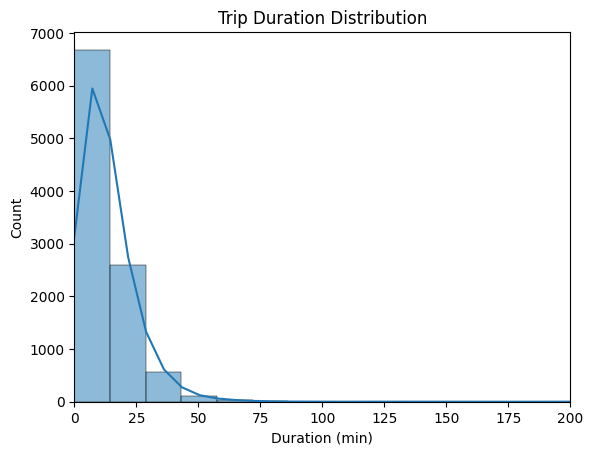

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(results_df_final['trip_duration'], bins=100, kde=True)
plt.xlim(0, 200)  # zoom in to see bulk distribution
plt.title('Trip Duration Distribution')
plt.xlabel('Duration (min)')
plt.show()

In [ ]:
# print(f"y: min={data.y.min().item():.2f}, max={data.y.max().item():.2f}, mean={data.y.mean().item():.2f}")

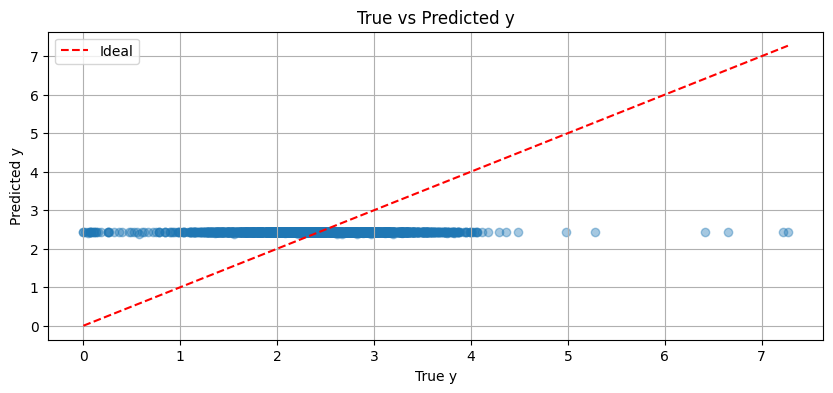

In [ ]:
import matplotlib.pyplot as plt

y_true = data.y[data.test_mask].cpu().numpy()
y_pred = model(data).detach().cpu().numpy()[data.test_mask.cpu().numpy()]

plt.figure(figsize=(10, 4))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("True vs Predicted y")
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Ideal')
plt.legend()
plt.grid(True)
plt.show()

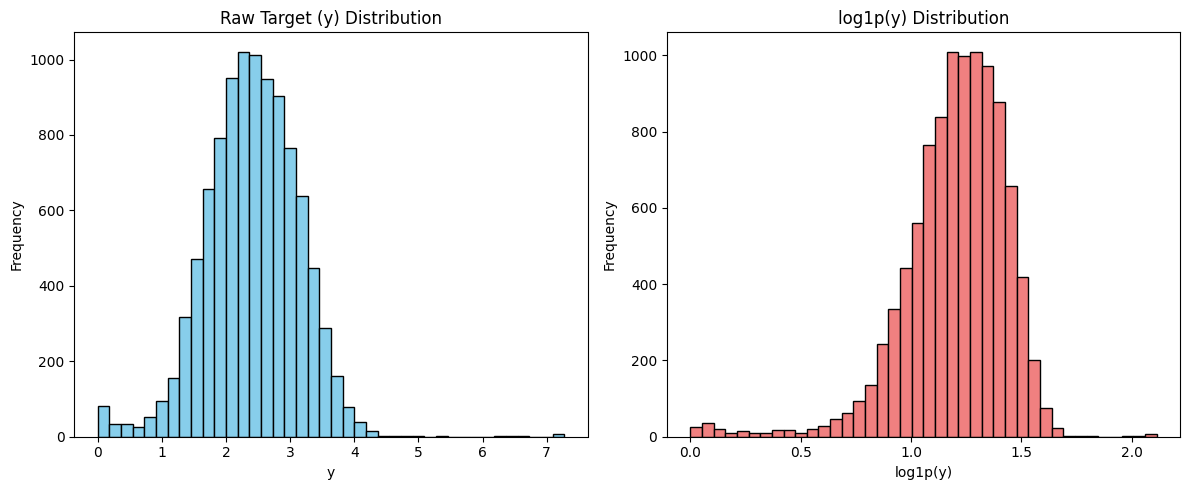

In [ ]:
# Assuming your data object is already loaded and moved to device
y = data.y.cpu().numpy()

plt.figure(figsize=(12, 5))

# Raw target distribution
plt.subplot(1, 2, 1)
plt.hist(y, bins=40, color='skyblue', edgecolor='black')
plt.title('Raw Target (y) Distribution')
plt.xlabel('y')
plt.ylabel('Frequency')

# Optionally, log1p-transformed target
plt.subplot(1, 2, 2)
plt.hist(np.log1p(y), bins=40, color='lightcoral', edgecolor='black')
plt.title('log1p(y) Distribution')
plt.xlabel('log1p(y)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

NameError: name 'feature_names' is not defined

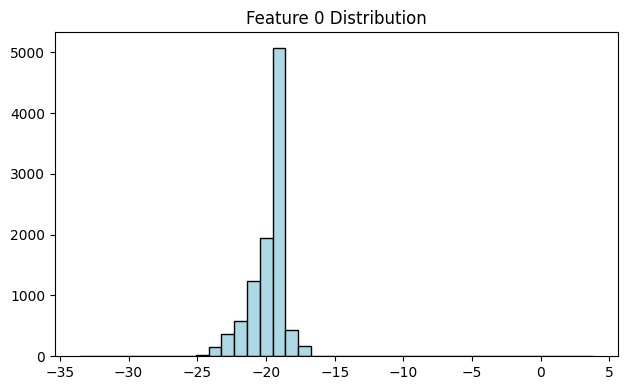

In [ ]:
x = data.x.cpu().numpy()
y = data.y.cpu().numpy()
num_features = x.shape[1]

# Plot all feature histograms
plt.figure(figsize=(16, 2.5 * num_features))
for i in range(num_features):
    plt.subplot((num_features + 1) // 2, 2, i + 1)
    plt.hist(x[:, i], bins=40, color='lightblue', edgecolor='black')
    plt.title(f'Feature {i} Distribution')
    plt.xlabel(feature_names[i])
    plt.tight_layout()
plt.show()

In [ ]:
# from torch_geometric.data import Data

# # Ensure edge indices and attributes are also tensors
# edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
# edge_attr_tensor = torch.tensor(data.edge_attr, dtype=torch.float)

# # Create PyTorch Geometric Data object
# data = Data(x=X, edge_index=edge_index_tensor, edge_attr=edge_attr_tensor, y=y)

In [ ]:
# from sklearn.model_selection import train_test_split

# # Get node indices
# num_nodes = data.x.shape[0]
# indices = np.arange(num_nodes)

# # Split into train/test (80/20)
# train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# # Define masks for PyTorch Geometric
# train_mask = torch.zeros(num_nodes, dtype=torch.bool)
# test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# train_mask[train_indices] = True
# test_mask[test_indices] = True

# # Assign masks to graph data object
# data.train_mask = train_mask
# data.test_mask = test_mask